## Gene Ontology Analysis

This notebook reproduces Fig. 2

Authors: Anna Ida Trolle and Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter
import scipy as sc
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
import pickle
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.stats.multitest
from functools import partial
from localcider.sequenceParameters import SequenceParameters
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from scipy import integrate
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import obonet
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

def map_to_curated_codes(graph, GO_terms, curated_GO_codes, nodes):
    new_codes = np.empty(0)
    for code in GO_terms:
        if code in nodes and code != 'unknown':
            ancestors = list(nx.dfs_predecessors(graph, source=code, depth_limit=None).values())
            ancestors += list(nx.dfs_predecessors(graph, source=code, depth_limit=None).keys())
            intersect = np.intersect1d(ancestors, curated_GO_codes)
            if intersect.size==0:
                intersect = np.append(intersect, 'other')
            new_codes = np.append(new_codes, intersect)
    return np.unique(new_codes).tolist()
    
def generate_BM_pvalues_csv(df_idrome,prop_nu,prop_SPR,GO_dict,nodes_cat,label):
    # Copy dict of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
    GO_terms = GO_dict.copy() 
    # Copy database
    df_GO = df_idrome.copy()
    
    g,u = np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum(),return_counts=True)
    curated_GO_codes = g[u>=200]
    curated_GO_codes = np.unique(np.intersect1d(curated_GO_codes,nodes_cat))
    curated_GO_terms = [id_to_name[x] for x in curated_GO_codes]
    GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, nodes_cat) )

    df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
    df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
    df_GO = df_GO[df_GO['count_GO_terms']>0]
    df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
        lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
    df_GO.drop('count_GO_terms',axis=1,inplace=True)
    
    print(df_GO.shape[0])
    
    pvalues = pd.DataFrame(index=curated_GO_terms)
    for name in curated_GO_terms:
        bool_term = df_GO.GO_terms.apply(lambda x : name in x).values
        pvalues.loc[name,'nu_two_sided'] = stats.brunnermunzel(df_GO[bool_term][prop_nu], 
                        df_GO[~bool_term][prop_nu], alternative='two-sided')[1]
        pvalues.loc[name,'nu_pvalue_g'] = stats.brunnermunzel(df_GO[bool_term][prop_nu], 
                        df_GO[~bool_term][prop_nu], alternative='greater')[1]
        pvalues.loc[name,'nu_pvalue_l'] = stats.brunnermunzel(df_GO[bool_term][prop_nu], 
                        df_GO[~bool_term][prop_nu], alternative='less')[1]
        
        if pvalues.loc[name,'nu_pvalue_l'] < pvalues.loc[name,'nu_pvalue_g']:
            pvalues.loc[name,'nu_one_sided'] = pvalues.loc[name,"nu_pvalue_l"]
            if pvalues.loc[name,'nu_one_sided'] < 1e-10:
                text_in_table = '\textcolor{orange}{'+f'$<${1e-10:.1g}'+'}'
            else:
                text_in_table = '\textcolor{orange}{'+f'{pvalues.loc[name,"nu_one_sided"]:.1g}'+'}'
            pvalues.loc[name,'nu_one_sided_table'] = text_in_table
        else:
            pvalues.loc[name,'nu_one_sided'] = pvalues.loc[name,"nu_pvalue_g"]
            if pvalues.loc[name,'nu_one_sided'] < 1e-10:
                text_in_table = '\textcolor{green}{'+f'$<${1e-10:.1g}'+'}'
            else:
                text_in_table = '\textcolor{green}{'+f'{pvalues.loc[name,"nu_one_sided"]:.1g}'+'}'
            pvalues.loc[name,'nu_one_sided_table'] = text_in_table
            
        pvalues.loc[name,'SPR_two_sided'] = stats.brunnermunzel(df_GO[bool_term][prop_SPR], 
                        df_GO[~bool_term][prop_SPR], alternative='two-sided')[1]
        pvalues.loc[name,'SPR_pvalue_g'] = stats.brunnermunzel(df_GO[bool_term][prop_SPR], 
                        df_GO[~bool_term][prop_SPR], alternative='greater')[1]
        pvalues.loc[name,'SPR_pvalue_l'] = stats.brunnermunzel(df_GO[bool_term][prop_SPR], 
                        df_GO[~bool_term][prop_SPR], alternative='less')[1]
        
        if pvalues.loc[name,'SPR_pvalue_l'] < pvalues.loc[name,'SPR_pvalue_g']:
            pvalues.loc[name,'SPR_one_sided'] = pvalues.loc[name,"SPR_pvalue_l"]
            if pvalues.loc[name,'SPR_one_sided'] < 1e-10:
                text_in_table = '\textcolor{orange}{'+f'$<${1e-10:.1g}'+'}'
            else:
                text_in_table = '\textcolor{orange}{'+f'{pvalues.loc[name,"SPR_one_sided"]:.1g}'+'}'
            pvalues.loc[name,'SPR_one_sided_table'] = text_in_table
        else:
            pvalues.loc[name,'SPR_one_sided'] = pvalues.loc[name,"SPR_pvalue_g"]
            if pvalues.loc[name,'SPR_one_sided'] < 1e-10:
                text_in_table = '\textcolor{green}{'+f'$<${1e-10:.1g}'+'}'
            else:
                text_in_table = '\textcolor{green}{'+f'{pvalues.loc[name,"SPR_one_sided"]:.1g}'+'}'
            pvalues.loc[name,'SPR_one_sided_table'] = text_in_table
            
        pvalues.loc[name,'n'] = df_GO[bool_term].shape[0]
    pvalues = pvalues.query('nu_one_sided<=1e-5 or SPR_one_sided<=1e-5').sort_values(by='nu_two_sided')
    pvalues.to_csv(f'go_analysis/GO_BM_pvalues_{label:s}.csv')
    return df_GO

#### Load basic version of the GO

In [19]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

#### Get nodes connected to molecular function, biological process, and cellular component

In [20]:
print(name_to_id['molecular_function'],name_to_id['biological_process'],name_to_id['cellular_component'])
molfunc = list(nx.ancestors(graph, 'GO:0003674')) # all nodes connected to molecular function
bioproc = list(nx.ancestors(graph, 'GO:0008150')) # all nodes connected to biological process
cellcom = list(nx.ancestors(graph, 'GO:0005575')) # all nodes connected to cellular component

GO:0003674 GO:0008150 GO:0005575


# Brunner Munzel Test on $\nu$ and $S_{conf}$ Distributions

In [21]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
GO_dict = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
df_GO_molfunc = generate_BM_pvalues_csv(df_idrome,'nu','SPR',GO_dict,molfunc,'molfunc')
df_GO_cellcom = generate_BM_pvalues_csv(df_idrome,'nu','SPR',GO_dict,cellcom,'cellcom')

df_GO_molfunc.to_pickle('go_analysis/df_GO_molfunc.pkl')
df_GO_cellcom.to_pickle('go_analysis/df_GO_cellcom.pkl')

22449
25368


In [26]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome = df_idrome.query('fdomain == 0')
GO_dict = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
_ = generate_BM_pvalues_csv(df_idrome,'nu','SPR',GO_dict,molfunc,'molfunc_no_domains')
_ = generate_BM_pvalues_csv(df_idrome,'nu','SPR',GO_dict,cellcom,'cellcom_no_domains')

17245
19620


In [27]:
df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)
GO_dict_spot = pd.Series(pd.read_pickle('go_analysis/uniprot_dict_SPOT.pkl')).to_frame(name='GO')
_ = generate_BM_pvalues_csv(df_idrome_spot,'nu_svr','SPR_svr',GO_dict_spot,molfunc,'molfunc_spot')
_ = generate_BM_pvalues_csv(df_idrome_spot,'nu_svr','SPR_svr',GO_dict_spot,cellcom,'cellcom_spot')

17136
19293


In [28]:
df_molfunc = pd.read_csv('go_analysis/GO_BM_pvalues_molfunc.csv',index_col=0)
df_molfunc_no_domains = pd.read_csv('go_analysis/GO_BM_pvalues_molfunc_no_domains.csv',index_col=0)
df_molfunc_spot = pd.read_csv('go_analysis/GO_BM_pvalues_molfunc_spot.csv',index_col=0)

df_cellcom = pd.read_csv('go_analysis/GO_BM_pvalues_cellcom.csv',index_col=0)
df_cellcom_no_domains = pd.read_csv('go_analysis/GO_BM_pvalues_cellcom_no_domains.csv',index_col=0)
df_cellcom_spot = pd.read_csv('go_analysis/GO_BM_pvalues_cellcom_spot.csv',index_col=0)

#### Tab. S1

In [29]:
df_molfunc_all = df_molfunc[['nu_one_sided','nu_one_sided_table','SPR_one_sided_table']].join(
                 df_molfunc_no_domains[['nu_one_sided_table','SPR_one_sided_table']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_molfunc_all = df_molfunc_all.join(
                 df_molfunc_spot[['nu_one_sided_table','SPR_one_sided_table']],how='outer')
df_molfunc_all = df_molfunc_all.sort_values('nu_one_sided')
df_molfunc_all.drop('nu_one_sided',axis=1,inplace=True)
df_molfunc_all.dropna().index
with pd.option_context("max_colwidth", 1000):
    a = df_molfunc_all.dropna().to_latex()
#print(a.replace('\\','').replace('textbackslash ','\\').replace(
#    'toprule','').replace('midrule','').replace('bottomrule','').replace('\n','\\\\\n\hline\n'))

#### Tab. S2

In [30]:
df_cellcom_all = df_cellcom[['nu_one_sided','nu_one_sided_table','SPR_one_sided_table']].join(
                 df_cellcom_no_domains[['nu_one_sided_table','SPR_one_sided_table']], 
                 lsuffix='_pLDDT', rsuffix='_nodomain', how='outer')
df_cellcom_all = df_cellcom_all.join(
                 df_cellcom_spot[['nu_one_sided_table','SPR_one_sided_table']],how='outer')
df_cellcom_all = df_cellcom_all.sort_values('nu_one_sided')
df_cellcom_all.drop('nu_one_sided',axis=1,inplace=True)
df_cellcom_all.dropna().index
with pd.option_context("max_colwidth", 1000):
    a = df_cellcom_all.dropna().to_latex()
#print(a.replace('\\','').replace('textbackslash ','\\').replace(
#    'toprule','').replace('midrule','').replace('bottomrule','').replace('\n','\\\\\n\hline\n'))

#### Fig. 2 _A_

transcription cis-regulatory region binding two-sided 0
transcription cis-regulatory region binding less 0
transcription cis-regulatory region binding greater 1
G protein-coupled receptor activity two-sided 3e-06
G protein-coupled receptor activity less 1
G protein-coupled receptor activity greater 1e-06
chromatin binding two-sided 1e-07
chromatin binding less 5e-08
chromatin binding greater 1
GTP binding two-sided 5e-08
GTP binding less 1
GTP binding greater 2e-08
ATP binding two-sided 1e-17
ATP binding less 1
ATP binding greater 7e-18
signaling receptor activity two-sided 1e-30
signaling receptor activity less 1
signaling receptor activity greater 5e-31


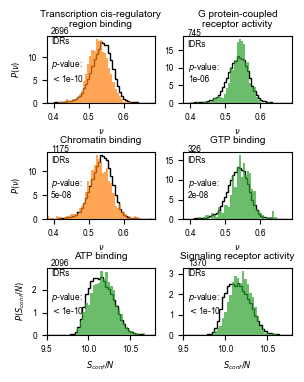

In [32]:
f, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(3,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['transcription cis-regulatory region binding','G protein-coupled receptor activity',
                    'chromatin binding','GTP binding'],axes.flatten()):
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values
    #bool_term *= (df_GO_molfunc.fdomain == 0)
    
    h = np.histogram(df_GO_molfunc[bool_term].nu,bins=bins,density=True)[0]
    
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
    
    ax.hist(df_GO_molfunc[~bool_term].nu,bins,density=True,histtype='step',color='k',zorder=0)

    res = stats.levene(df_GO_molfunc[bool_term].nu, df_GO_molfunc[~bool_term].nu)
    statistic, p_twosided = stats.brunnermunzel(df_GO_molfunc[bool_term].nu, 
                                                df_GO_molfunc[~bool_term].nu, alternative='two-sided')
    statistic, p_less = stats.brunnermunzel(df_GO_molfunc[bool_term].nu, 
                                            df_GO_molfunc[~bool_term].nu, alternative='less')
    statistic, p_greater = stats.brunnermunzel(df_GO_molfunc[bool_term].nu, 
                                               df_GO_molfunc[~bool_term].nu, alternative='greater')
    
    p_value = p_twosided
    if p_twosided<0.05 and p_less<0.05 and p_less<p_greater:
        color = 'tab:orange'
        label = f'{p_twosided:.1g}'
        p_value = p_less
        if p_twosided<p_less:
            print('p_twosided<p_less')
    elif p_twosided<0.05 and p_greater<0.05:
        color = 'tab:green'
        label = f'{p_twosided:.1g}'
        p_value = p_greater
        if p_twosided<p_greater:
            print('p_twosided<p_greater')
    else:
        color = 'k'
        
    print(name,'two-sided',f'{p_twosided:.1g}')
    print(name,'less',f'{p_less:.1g}')
    print(name,'greater',f'{p_greater:.1g}')
    
    p_value_label = f'{p_value:.1g}' if p_value >= 1e-10 else '$<$1e-10'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color,
          label=f'{N_IDRs:d}\nIDRs'+f'\n\n$p$-value:\n'+p_value_label)
    
    if name == 'transcription cis-regulatory region binding':
        ax.set_title('Transcription cis-regulatory\nregion binding')
    elif name == 'GTP binding':
        ax.set_title('GTP binding')
    elif name == 'chromatin binding':
        ax.set_title('Chromatin binding')
    elif name == 'G protein-coupled receptor activity':
        ax.set_title('G protein-coupled\nreceptor activity')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(.38,.69)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.02,.28))
    legend.get_title().set_ha('center')  
    
bin_width = .03
bins = np.arange(9.3, 11.5,bin_width)
x = bins[:-1]+bin_width/2.

for name,ax in zip(['ATP binding',
                    'signaling receptor activity'],axes.flatten()[-2:]):
    bool_term = df_GO_molfunc.GO_terms.apply(lambda x : name in x).values
    bool_term *= (df_GO_molfunc.fdomain == 0)
    
    h = np.histogram(df_GO_molfunc[bool_term].SPR,bins=bins,density=True)[0]
        
    N_IDRs = df_GO_molfunc[bool_term].shape[0]
    
    ax.hist(df_GO_molfunc[~bool_term].SPR,bins,density=True,histtype='step',color='k',zorder=0)

    res = stats.levene(df_GO_molfunc[bool_term].SPR, df_GO_molfunc[~bool_term].SPR)
    statistic, p_twosided = stats.brunnermunzel(df_GO_molfunc[bool_term].SPR, 
                                                df_GO_molfunc[~bool_term].SPR, alternative='two-sided')
    statistic, p_less = stats.brunnermunzel(df_GO_molfunc[bool_term].SPR, 
                                            df_GO_molfunc[~bool_term].SPR, alternative='less')
    statistic, p_greater = stats.brunnermunzel(df_GO_molfunc[bool_term].SPR, 
                                               df_GO_molfunc[~bool_term].SPR, alternative='greater')
    
    p_value = p_twosided
    if p_twosided<0.05 and p_less<0.05 and p_less<p_greater:
        color = 'tab:orange'
        label = f'{p_twosided:.1g}'
        p_value = p_less
        if p_twosided<p_less:
            print('p_twosided<p_less')
    elif p_twosided<0.05 and p_greater<0.05:
        color = 'tab:green'
        label = f'{p_twosided:.1g}'
        p_value = p_greater
        if p_twosided<p_greater:
            print('p_twosided<p_greater')
    else:
        color = 'k'
        
    print(name,'two-sided',f'{p_twosided:.1g}')
    print(name,'less',f'{p_less:.1g}')
    print(name,'greater',f'{p_greater:.1g}')
    
    p_value_label = f'{p_value:.1g}' if p_value >= 1e-10 else '$<$1e-10'
    
    ax.bar(x,h,alpha=.7,width=bin_width,color=color,
          label=f'{N_IDRs:d}\nIDRs'+f'\n\n$p$-value:\n'+p_value_label)
    if name == 'ATP binding':
        ax.set_title('ATP binding')
    else:
        ax.set_title(name.capitalize())
    ax.set_xlim(9.5,10.8)
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.02,.28))
    legend.get_title().set_ha('center')    
    
for ax in axes[:2,:].flatten():
    ax.set_xlabel('$\\nu$')
for ax in axes[:2,0]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[-1,:]:
    ax.set_xlabel('$S_{conf}/N$')
for ax in axes[-1:,0]:
    ax.set_ylabel('$P(S_{conf}/N)$')    
    
plt.tight_layout(h_pad=0)
plt.savefig('figs/fig2_molfunc.pdf')
plt.show()

#### Fig. 2 _B_

nucleus two-sided 0
nucleus less 0
nucleus greater 1
nuclear body two-sided 1e-06
nuclear body less 7e-07
nuclear body greater 1
mitochondrion two-sided 2e-27
mitochondrion less 1
mitochondrion greater 1e-27
endosome two-sided 6e-16
endosome less 1
endosome greater 3e-16
chromatin two-sided 3e-09
chromatin less 2e-09
chromatin greater 1


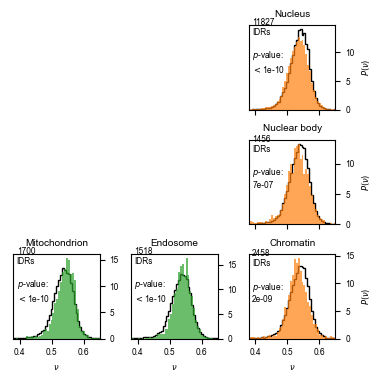

In [33]:
f, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(3.8,3.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bin_width = .006
bins = np.arange(0.25, .74,bin_width)
x = bins[:-1]+bin_width/2.

for name,i in zip(['nucleus','nuclear body','mitochondrion','endosome','chromatin'],[2,5,6,7,8]):
    ax = axes.flatten()[i]
    bool_term = df_GO_cellcom.GO_terms.apply(lambda x : name in x).values
    h_1 = np.histogram(df_GO_cellcom[~bool_term].nu,bins=bins,density=True)[0]
    h_2 = np.histogram(df_GO_cellcom[bool_term].nu,bins=bins,density=True)[0]
    
    N_IDRs = df_GO_cellcom[bool_term].shape[0]
    N_all_IDRs = df_GO_cellcom.shape[0]
    
    ax.hist(df_GO_cellcom[~bool_term].nu,bins,density=True,histtype='step',color='k',zorder=0)
    
    statistic, p_twosided = stats.brunnermunzel(df_GO_cellcom[bool_term].nu, df_GO_cellcom[~bool_term].nu, 
                                            alternative='two-sided')
    print(name,'two-sided',f'{p_twosided:.1g}')
    statistic, p_less = stats.brunnermunzel(df_GO_cellcom[bool_term].nu, df_GO_cellcom[~bool_term].nu, 
                                            alternative='less')
    print(name,'less',f'{p_less:.1g}')
    statistic, p_greater = stats.brunnermunzel(df_GO_cellcom[bool_term].nu, df_GO_cellcom[~bool_term].nu, 
                                            alternative='greater')
    print(name,'greater',f'{p_greater:.1g}')
    
    p_value = p_twosided
    if p_twosided<0.05 and p_less<0.05 and p_less<p_greater:
        color = 'tab:orange'
        label = f'{p_twosided:.1g}'
        p_value = p_less
        if p_twosided<p_less:
            print('p_twosided<p_less')
    elif p_twosided<0.05 and p_greater<0.05:
        color = 'tab:green'
        label = f'{p_twosided:.1g}'
        p_value = p_greater
        if p_twosided<p_greater:
            print('p_twosided<p_greater')
    else:
        color = 'k'
        
    p_value_label = f'{p_value:.1g}' if p_value >= 1e-10 else '$<$1e-10'
    
    ax.bar(x,h_2,alpha=.7,width=bin_width,color=color,
           label=f'{N_IDRs:d}\nIDRs'+f'\n\n$p$-value:\n'+p_value_label)

    ax.set_title(name.capitalize())

    ax.set_xlim(.38,.65)
    ax.set_xticks([.4,.5,.6])
    legend = ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.04,.41))

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
for ax in axes[-1,:]:
    ax.set_xlabel('$\\nu$')
for ax in axes[:,2]:
    ax.set_ylabel('$P(\\nu)$')
for ax in axes[:2,:2].flatten():
    ax.axis('off')
plt.tight_layout()
plt.savefig('figs/fig2_cellcom.pdf')
plt.show()

#### Searching for TFs analysed by Staller et al. (DOI: https://doi.org/10.1016/j.cels.2022.01.002)

In [34]:
dataset_3 = pd.read_csv('https://ars.els-cdn.com/content/image/1-s2.0-S2405471222000023-mmc4.csv',
           storage_options={'User-Agent': 'Mozilla/5.0'},index_col=2)

tfs_staller = []

df_staller = df_GO_molfunc[df_GO_molfunc.UniProt_ID.apply(lambda x: x[0]).isin(dataset_3.index)]
bool_term = df_staller.GO_terms.apply(lambda x : 'transcription cis-regulatory region binding' in x).values
df_staller = df_staller[bool_term].query('nu <= 0.475')
for idr in df_staller.index:
    if type(dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq) == str:
        if dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq in df_staller.loc[idr].fasta:
            print(df_staller.loc[idr].protein_name,df_staller.loc[idr].nu)
            tfs_staller.append(idr)
    else:
        for seq in dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq.values:
            if seq in df_staller.loc[idr].fasta:
                print(df_staller.loc[idr].protein_name,df_staller.loc[idr].nu)
                tfs_staller.append(idr)
print(np.unique(tfs_staller).size)

Forkhead box protein O6 0.455
Transcription factor SOX-11 0.474
Forkhead box protein O4 0.443
Zinc finger protein interacting with ribonucleoprotein K 0.472
Coiled-coil and C2 domain-containing protein 1A 0.438
Pancreas transcription factor 1 subunit alpha 0.401
Zinc finger and BTB domain-containing protein 46 0.456
Adipocyte enhancer-binding protein 1 0.438
Zinc finger protein 561 0.454
Zinc finger protein 473 0.439
HMG box transcription factor BBX 0.413
Zinc finger protein 419 0.464
Zinc finger protein 42 homolog 0.468
Homeobox protein ARX 0.41
ETS-related transcription factor Elf-4 0.448
Zinc finger protein 644 0.438
PR domain zinc finger protein 5 0.457
CXXC-type zinc finger protein 1 0.456
Zinc finger protein 639 0.465
Zinc finger protein 777 0.412
20


In [35]:
dataset_3 = pd.read_csv('https://ars.els-cdn.com/content/image/1-s2.0-S2405471222000023-mmc4.csv',
           storage_options={'User-Agent': 'Mozilla/5.0'},index_col=2)

tfs_staller = []

df_staller = df_GO_molfunc[df_GO_molfunc.UniProt_ID.apply(lambda x: x[0]).isin(dataset_3.index)]
for idr in df_staller.index:
    if type(dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq) == str:
        if dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq in df_staller.loc[idr].fasta:
            #print(df_staller.loc[idr].protein_name,df_staller.loc[idr].GO_terms)
            tfs_staller.append(idr)
    else:
        for seq in dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq.values:
            if seq in df_staller.loc[idr].fasta:
                #print(df_staller.loc[idr].protein_name,df_staller.loc[idr].GO_terms)
                tfs_staller.append(idr)
print(np.unique(tfs_staller).size)

107


#### Proteins with compact IDRs that localize in intracellular membraneless organelles

In [36]:
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
go_ids_mlos = [name_to_id[name] for name in ['intracellular non-membrane-bounded organelle']]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, go_ids_mlos, cellcom) )
nuc_mos = GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID][
    GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_mlos for i in x])>0).values].index.unique()
nuc_mos.size, 'intracellular non-membrane-bounded organelle'

(340, 'intracellular non-membrane-bounded organelle')

#### Proteins with compact IDRs that localize in nucleoli, nuclear speckles, nuclear bodies, and PML bodies

In [37]:
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
go_ids_nuclear_condensates = [name_to_id[name] for name in ['nucleolus','nuclear speck','nuclear body','PML body']]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, go_ids_nuclear_condensates, cellcom) )
nuc_mos = GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID][
    GO_terms.loc[df_idrome.query('nu <= 0.475').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_nuclear_condensates for i in x])>0).values].index.unique()
nuc_mos.size, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body'

(189, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body')

#### Example: Find IDRs with a specific GO term

In [38]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)
# Map GO terms that have catalytic activity as parent term
curated_GO_codes = ['GO:0003824']
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, molfunc) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO['GO_terms'] = df_GO.GO_terms.apply(lambda x : 0 if x==['other'] else x[0])
df_GO.drop('count_GO_terms',axis=1,inplace=True)
df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: x[0])

df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome['is_enzyme'] = False
df_idrome.loc[df_GO.query('GO_terms != 0').index,'is_enzyme'] = True 

df_idrome.query('is_enzyme').protein_name

seq_name
A0A024RBG1_145_181    Diphosphoinositol polyphosphate phosphohydrola...
A0A0B4J2F2_350_783       Putative serine/threonine-protein kinase SIK1B
A0A0B4J2F2_278_307       Putative serine/threonine-protein kinase SIK1B
A0A0U1RR11_239_272                  Centromere protein V-like protein 1
A0A0U1RR11_1_90                     Centromere protein V-like protein 1
                                            ...                        
Q9Y6X9_576_795                                             ATPase MORC2
Q9Y6Y8_1_269                                  SEC23-interacting protein
Q9Y6Y8_595_653                                SEC23-interacting protein
Q9Y6Y8_709_773                                SEC23-interacting protein
Q9Y6Y8_853_947                                SEC23-interacting protein
Name: protein_name, Length: 6731, dtype: object